In [ ]:
# !pip install nuscenes-devkit

In [ ]:
# # Make folder and download
# !mkdir -p content/nuscenes_data
# !wget https://www.nuscenes.org/data/v1.0-mini.tgz -O content/nuscenes_data/v1.0-mini.tgz

# # Extract
# !tar -xvzf content/nuscenes_data/v1.0-mini.tgz -C content/nuscenes_data

In [10]:
import os
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from PIL import Image, ImageDraw
from nuscenes.nuscenes import NuScenes
import pandas as pd
from IPython.display import display, HTML
import base64
import shutil

In [1]:
pwd

'/blue/iruchkin/koshyreshma/multi-modal'

In [3]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load model and processor
model_name = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.30s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
# Setup nuScenes mini dataset
NUSCENES_ROOT = "/blue/iruchkin/koshyreshma/multi-modal/content/nuscenes_data"
CAMERA_NAMES = ["CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT", "CAM_BACK", "CAM_BACK_LEFT", "CAM_FRONT_LEFT"]

nusc = NuScenes(version='v1.0-mini', dataroot=NUSCENES_ROOT, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.934 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [6]:
def stitch_images(images, rows=2, cols=3, border_color="black", border_width=5):
    w, h = images[0].size  # Assumes all images are the same size
    stitched_img = Image.new('RGB', (cols * w, rows * h))  # Create a blank canvas for stitching
    draw = ImageDraw.Draw(stitched_img)  # Prepare to draw borders

    for idx, img in enumerate(images):
        row_idx = idx // cols  # Determine the row index
        col_idx = idx % cols   # Determine the column index
        x_offset = col_idx * w  # X coordinate for pasting image
        y_offset = row_idx * h  # Y coordinate for pasting image
        
        stitched_img.paste(img, (x_offset, y_offset))  # Place each image in its position
        
        # Draw borders around the images (excluding the last row/column)
        if col_idx < cols - 1:  # Draw right border for non-last column
            draw.line((x_offset + w, y_offset, x_offset + w, y_offset + h), fill=border_color, width=border_width)
        if row_idx < rows - 1:  # Draw bottom border for non-last row
            draw.line((x_offset, y_offset + h, x_offset + w, y_offset + h), fill=border_color, width=border_width)

    return stitched_img

In [7]:
# Function to generate caption for a single image
def generate_caption(image, prompt="Describe this image in detail:"):
    inputs = processor.apply_chat_template(
        [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}]}],
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        padding=True,
        return_tensors="pt"
    ).to(device, torch.float16)
    
    with torch.no_grad():
        generate_ids = model.generate(**inputs, max_new_tokens=300)
        caption = processor.batch_decode(generate_ids, skip_special_tokens=True)[0]
    
    return caption

In [8]:
# Loop through samples
results = []
sample_size_for_captioning = 1
for idx, sample in enumerate(nusc.sample[:sample_size_for_captioning]):  # Limit to first 10 samples
    sample_token = sample['token']
    images = []
    
    for cam in CAMERA_NAMES:
        cam_token = sample['data'][cam]
        cam_data = nusc.get('sample_data', cam_token)
        cam_filename = os.path.join(NUSCENES_ROOT, cam_data['filename'])
        img = Image.open(cam_filename).convert("RGB").resize((640, 360))
        images.append(img)
    
    stitched_img = stitch_images(images, rows=2, cols=3)
    prompt = """
You are an expert autonomous driving system. The following images represent a 360-degree view of the scene around the vehicle, collected from multiple camera angles arranged in a 2x3 layout(two rows, three columns) in the order: Row 1: CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_RIGHT, Row 2: CAM_BACK, CAM_BACK_LEFT, CAM_FRONT_LEFT (left to right). 

Please describe this scene in **two parts** with the following structure:

1. **Scene Description**:  
   Describe the entire 360-degree scene as captured by these six camera views. Focus on **road conditions**, **nearby vehicles**, **pedestrians**, **obstacles**, and other relevant details that a driver should be aware of from each camera’s perspective. 
   - Mention the **layout** and **interaction** between objects in the environment, such as whether there is a vehicle ahead, pedestrians to the right, or any road signs or barriers.

2. **Driving Awareness**:  
   Based on the scene described, provide insights into what a **driver should focus on** and **how to proceed**. Consider aspects like:
   - **Safe driving decisions**: Should the driver slow down, change lanes, prepare to stop becuase it is red signal, or stop because of a pedestrain?
   - **Contextual awareness**: Are there any vehicles or obstacles ahead, to the sides, or behind the car that need attention?
   - **What actions should the driver take next** based on the situational context described above.

Please ensure that both the Scene Description, Driving Awareness are clearly separated by a neweline and describe only practical, concise useful steps to take and not general safety/siutational awareness. Keep it as concise as possible so do not include overall summary or general statements. No fluff, to the point.
"""
    caption = generate_caption(stitched_img, prompt)
    
    results.append({
        "sample_token": sample_token,
        "stitched_image": stitched_img,
        "caption": caption
    })

    print(f"Processed {idx+1}/{sample_size_for_captioning} samples")

Processed 1/1 samples


In [11]:
# Save results to HTML

output_dir = "/blue/iruchkin/koshyreshma/multi-modal/nuscenes_mini_captions_output"

# Clear the directory if it already exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Create a fresh empty directory
os.makedirs(output_dir)

html_lines = ['<html><head><title>nuScenes Mini Captions</title></head><body>']
html_lines.append('<h1>nuScenes Mini 360° Scene Captions</h1>')

for res in results:
    sample_id = res['sample_token']
    caption = res['caption']  # The generated caption
    prompt = "You are an expert autonomous driving system. The following images represent a 360-degree view of the scene around the vehicle..."  # Replace with actual prompt used
    
    img_path = os.path.join(output_dir, f"{sample_id}.jpg")
    res['stitched_image'].save(img_path)
    
    # Split the caption into user and assistant parts
    if "ASSISTANT:" in caption:
        user_prompt, assistant_response = caption.split("ASSISTANT:", 1)
    else:
        user_prompt, assistant_response = caption, ""  # In case there's no "ASSISTANT:" in the response
    
    # Clean up any extra spaces or newlines
    user_prompt = user_prompt.strip()
    assistant_response = assistant_response.strip()
    
    # Add sample image
    html_lines.append(f'<h2>Sample: {sample_id}</h2>')
    
    with open(img_path, "rb") as img_file:
        b64_string = base64.b64encode(img_file.read()).decode("utf-8")
    
    html_lines.append(f'<img src="data:image/jpeg;base64,{b64_string}"><br>')

    # Separate the User's input and Assistant's response
    html_lines.append(f'<p><b>User Input:</b><br>{user_prompt}</p><br>')  # User's input
    html_lines.append(f'<p><b>Assistant Response:</b><br>{assistant_response}</p><br>')  # Assistant's response
    
    html_lines.append('<hr>')

html_lines.append('</body></html>')

html_content = '\n'.join(html_lines)
html_file_path = os.path.join(output_dir, "index.html")

# Save the HTML file
with open(html_file_path, "w") as f:
    f.write(html_content)

print(f"Results saved in folder '{output_dir}'")
print(f"Open '{html_file_path}' in a browser to review images and captions.")


Results saved in folder '/blue/iruchkin/koshyreshma/multi-modal/nuscenes_mini_captions_output'
Open '/blue/iruchkin/koshyreshma/multi-modal/nuscenes_mini_captions_output/index.html' in a browser to review images and captions.


In [ ]:
# pwd
# from IPython.display import Image, display
# display(Image(filename="nuscenes_mini_captions_output/39586f9d59004284a7114a68825e8eec.jpg"))


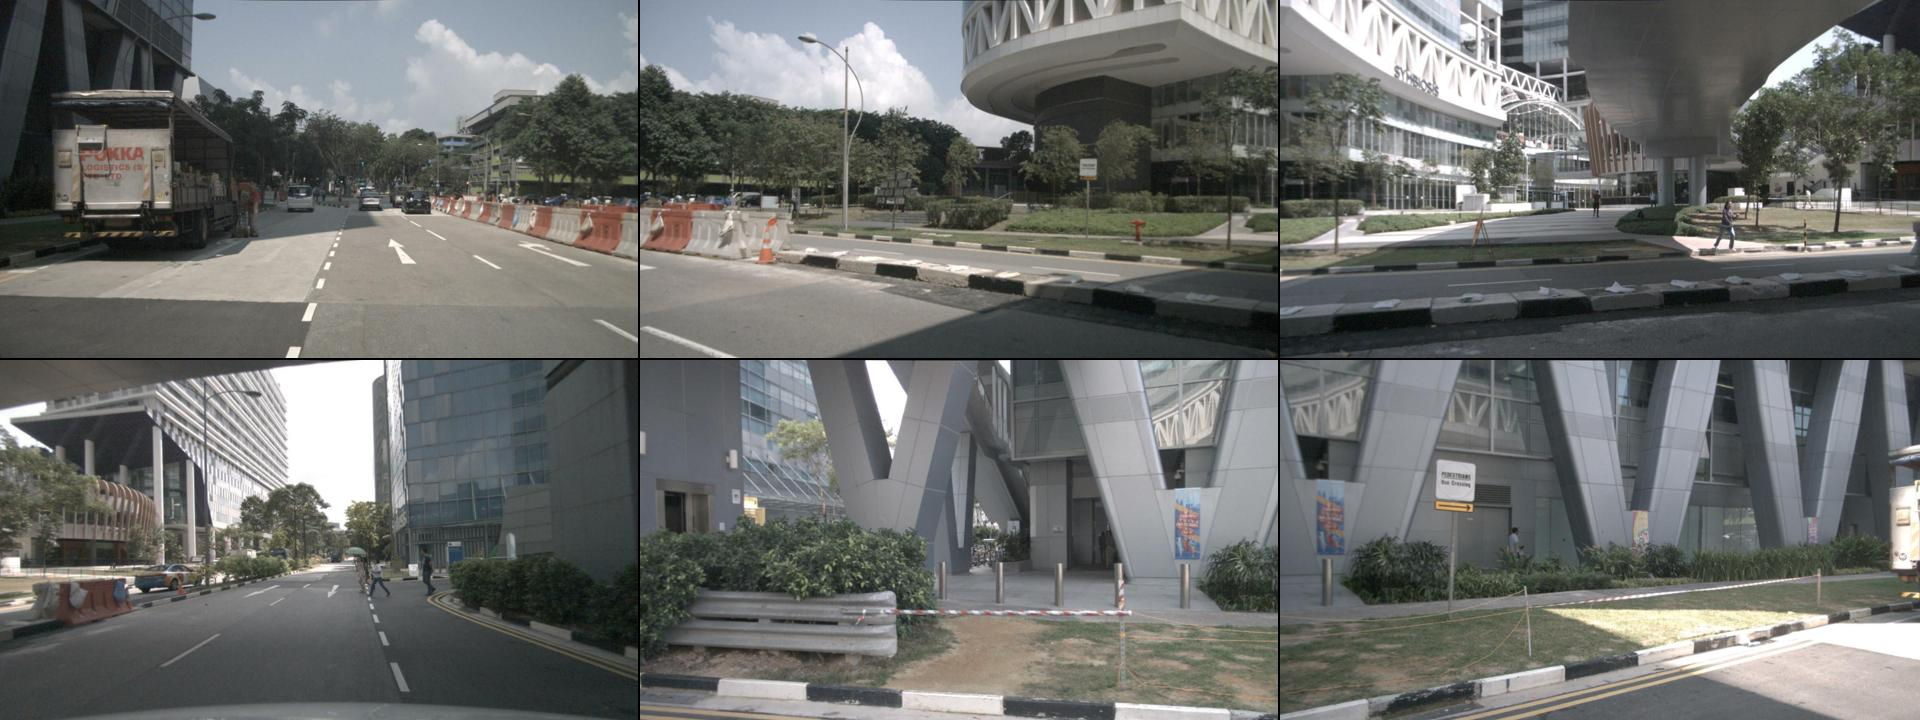

In [12]:
# Display HTML inside notebook
try:
    display(HTML(html_content))
except:
    pass